# Housekeeping

In [344]:
# -------------------- Imports -------------------- #
from pathlib import Path
import string
import math
import pprint as pp
from multiprocessing import Pool
import time

# Third party
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
from labellines import labelLines
import statsmodels.api as sm

In [345]:
# ----- Figure Style ----- #
# print(plt.style.available) # Uncomment to print available styles
plt.style.use('seaborn-talk')

# ----- Font Size ----- #
FONT_SIZE = 20
matplotlib.rc('xtick', labelsize=FONT_SIZE) 
matplotlib.rc('ytick', labelsize=FONT_SIZE)
matplotlib.rcParams.update({'font.size': FONT_SIZE})

# ----- Figure Size ----- #
FIGURE_SIZE     = (10, 4)
FIGURE_DPI      = 300
plt.rcParams["figure.figsize"] = FIGURE_SIZE

# Helpers

In [346]:
def split(l, n):
    '''
    Split a list l, into n chunks of, best effot, equal size
    '''
    
    k, m = divmod(len(l), n)
    return list(l[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [347]:
def test_beta_zero(X, Y, a=0.05):
    '''
    :param X (matrix like): design matrix with two columns: 
                            a column of 1's (the constant / intercept)
                            a column of values
    :param Y (list like): observations
    :param a (float): ratio of type 1 error
    
    :return (dict): {
        'beta'      : beta,  # estimate of beta one
        'intercept' : intercept,
        'sse'       : sum square residuals,
        't'         : t value,
        'cil'       : low value of the confidence interval,
        'cih'       : high value of the confidence interval,
        'h0'        : result of the t-test 
                        (True or 1.0 = Accept H0, False or 0.0 = Reject H0)
    }
    '''
    
    mod = sm.OLS(Y, X)
    res = mod.fit()

    intercept = res.params[0]
    beta = res.params[1]
    sse = np.sum( res.resid ** 2)
    t = res.tvalues[1]
    ci = res.conf_int(alpha=a).iloc[1]

    h0 = False
    if ci[0] <= 0 <= ci[1]:
        h0 = True

    return {
        'beta'     : beta,
        'intercept' : intercept,
        'sse'       : sse,
        't'         : t,
        'cil'       : ci[0],
        'cih'       : ci[1],
        'h0'        : h0,
    } 

In [348]:
def plot_beta_confidence(results_df, names, title, figsize=FIGURE_SIZE, ascending=True):
    '''
    Plot the slope estimae and confidence interval of beta for several names 
    (region, sectors, etc)
    
    :param results_df (dataframe): with columns 'beta' and 'name'
    :param names (list): list of names to plot
    :param title (str): title of plot
    '''
    
    results_copy_df = results_df.copy(deep=True)
    results_copy_df = results_copy_df[ results_copy_df['name'].isin(names) ]
    results_copy_df.sort_values('beta', inplace=True, ascending=ascending)

    plt.rcParams["figure.figsize"] = figsize
    
    plt.errorbar(
        results_copy_df['beta'],
        results_copy_df['name'],
        xerr=[results_copy_df['beta'] - results_copy_df['cil'], results_copy_df['cih'] - results_copy_df['beta']],
        fmt='o',
    )
    plt.grid()

    plt.title(title, fontsize=FONT_SIZE, y=1.02)
    plt.show()

In [349]:
def test_reduced_model(X, Y, columns_to_drop, a=0.05):
    '''
    Given a full model (X) and outcomes (Y), returns the result of an
    f test between X and X without the columns in columns_to_drop.
    
    :param X (matrix like): design matrix of m rows and n columns
    :param Y (list like): m outcomes
    :param columns_to_drop (list like): list of column indeces or names
    :param a (number): probability of type 1 error
    :return (dict): {
        'betas_full'  : beta estimates of full model,
        'betas_rest'  : beta estimates of reduced model,
        'f_value'     : f statistic value between full and reduced model,
        'f_threshold' : f value for type 1 error equal to a,
        'h0'          : whether to accept (True / 1.0) or reject (False / 0.0) 
                            the reduced model,
    }
    '''
    
    # Convert columns_to_drop from indeces to labels
    if not set(columns_to_drop).issubset(set(X.columns)):
        columns_to_drop = X.columns[columns_to_drop]
    
    X_rest = X.drop(columns=columns_to_drop)
    X_full = X
    
    res_full = sm.OLS(Y, X_full).fit()
    res_rest = sm.OLS(Y, X_rest).fit()
    
    betas_full = res_full.params
    betas_rest = res_rest.params
    
    f_value = res_full.compare_f_test(res_rest)[0]
    
    f_num       = res_full.df_model - res_rest.df_model
    f_den       = res_full.df_resid
    f_threshold = scipy.stats.f.ppf(1 - a, f_num, f_den)
    
    h0 = f_value < f_threshold
    
    return {
        'betas_full'  : betas_full,
        'betas_rest'  : betas_rest,
        'f_value'     : f_value,
        'f_threshold' : f_threshold,
        'h0'          : h0,
    }

In [350]:
def plot_f_and_threshold(results_df, names, title, figsize=FIGURE_SIZE, ascending=True):
    '''
    Plot the f value and threshold for several names (region, sectors, etc)
    
    :param results_df (dataframe): with columns 'f_value', 'f_threshold' and 'name'
    :param names (list): list of names to plot
    :param title (str): title of plot
    '''
    
    results_copy_df = results_df.copy(deep=True)
    results_copy_df = results_copy_df[ results_copy_df['name'].isin(names) ]
    results_copy_df.sort_values('f_value', inplace=True, ascending=ascending)
    results_copy_df.reset_index(drop=True, inplace=True)

    f_threshold = results_copy_df.iloc[0]['f_threshold']

    plt.rcParams["figure.figsize"] = figsize

    plt.scatter(
        results_copy_df['f_value'],
        results_copy_df['name'],
    )

    plt.axvline(f_threshold, color='r')
    plt.grid()
    plt.title(title, fontsize=FONT_SIZE, y=1.02)
    plt.xlabel('f Values and Threshold (Red Line)', fontsize=FONT_SIZE)
    plt.show()

# Data

In [351]:
data_path = Path("Data")

repi_by_sector_df = pd.read_csv(data_path / 'Real Estate Price Index.csv')
repi_by_region_df = pd.read_csv(data_path / 'Real Estate Price Index - by Region.csv')

# Fix the Data

1. Convert year and quarters to floats (time)

In [352]:
repi_by_sector_df['time'] = pd.to_numeric(repi_by_sector_df['Year']) + \
                            (pd.to_numeric(repi_by_sector_df['Quarter']))/4
repi_by_region_df['time'] = pd.to_numeric(repi_by_region_df['Year']) + \
                            (pd.to_numeric(repi_by_region_df['Quarter']))/4

# Linear Model

## Null test (slope = 0)

In [353]:
linear_results_df = pd.DataFrame()
a = 0.05

# ----- Per sector
sectors = ['General', 'Residential', 'Commercial', 'Agricultural']
X = sm.add_constant(repi_by_sector_df[['time']])

for sector in sectors:
    Y = repi_by_sector_df[sector]
    
    name = sector
    if name == 'General':
        name = 'Kingdom'

    res = test_beta_zero(X, Y, a)
    res['name'] = name

    linear_results_df = linear_results_df.append(res, ignore_index=True)
    
# ----- Per region (plus Kingdom)
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')
for region in regions:
    region_df = repi_by_region_df[ repi_by_region_df['Region'] == region ]
    
    X = sm.add_constant(region_df[['time']])
    Y = region_df['All']
        
    res = test_beta_zero(X, Y, a)
    res['name'] = region

    linear_results_df = linear_results_df.append(res, ignore_index=True)
    
linear_results_df

,beta,cih,cil,h0,intercept,name,sse,t
0,-4.747988,-3.989412,-5.506563,0.0,9666.123529,Kingdom,62.038080,-13.268667
1,-3.862539,-3.052141,-4.672936,0.0,7882.554248,Residential,70.803928,-10.103947
2,-6.780186,-5.971942,-7.588430,0.0,13759.747059,Commercial,70.428111,-17.783427
3,-1.650361,-1.198596,-2.102126,0.0,3423.547059,Agricultural,22.003199,-7.744314
4,-6.860484,-5.723491,-7.997476,0.0,13925.707694,Ar Riyad,46.464184,-13.146704
5,-5.597861,-4.382699,-6.813022,0.0,11379.751465,Makkah,53.072672,-10.037093
6,-2.440352,-2.093592,-2.787111,0.0,5018.924945,Madinah,4.321741,-15.333609
7,-3.970930,-2.791863,-5.149998,0.0,8099.756922,Eastern,49.966651,-7.337929
8,-4.722315,-3.465285,-5.979345,0.0,9611.819817,Al Qaseem,56.792906,-8.185199
9,-2.991092,-1.852435,-4.129748,0.0,6121.634249,Aseer,46.600265,-5.723436


## Confidence intervals

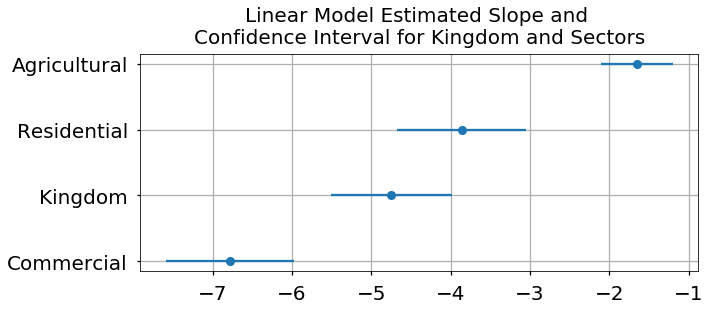

In [354]:
# Sector slope and CI
sectors = ['Kingdom', 'Residential', 'Commercial', 'Agricultural']
title = 'Linear Model Estimated Slope and \nConfidence Interval for Kingdom and Sectors'
plot_beta_confidence(linear_results_df, sectors, title, figsize=(10,4) ,ascending=True)

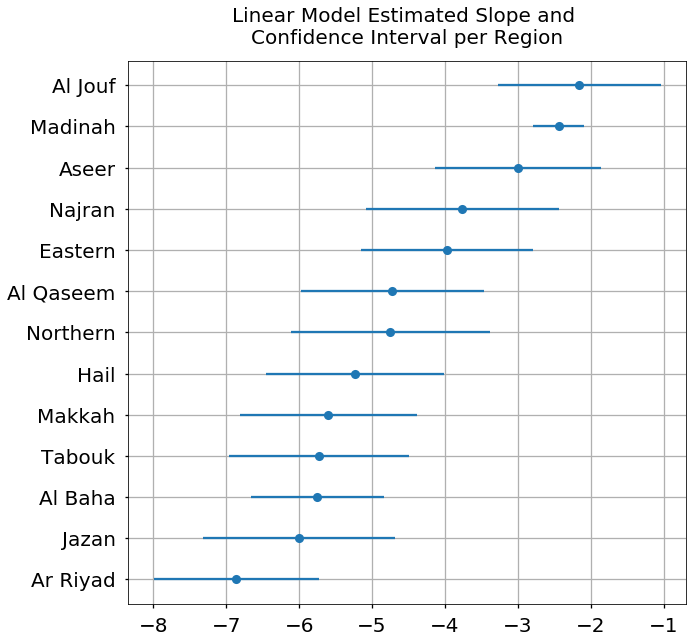

In [355]:
# Regional slope and CI
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')
title = 'Linear Model Estimated Slope and \nConfidence Interval per Region'
plot_beta_confidence(linear_results_df, regions, title, figsize=(10,10) ,ascending=True)

## Plot Line Estimates

In [356]:
def plot_estimated_line(results_df, data_df, names, title, figsize=FIGURE_SIZE, xvals=None):

    x_min = data_df['time'].min()
    x_max = data_df['time'].max()
    x = np.linspace(x_min, x_max, 1000)
    
    plt.rcParams["figure.figsize"] = figsize

    for name in names:
        result    = results_df[ results_df['name'] == name].iloc[0]
        slope     = result['beta']
        intercept = result['intercept']

        estimate_y = x*slope + intercept
    
        plt.plot(
            x,
            estimate_y,
            label=name
        )

    plt.title(title, fontsize=FONT_SIZE)
    
    if xvals is None:
        plt.legend()
    elif type(xvals) == list:
        labelLines(plt.gca().get_lines(), align=True, fontsize=12, xvals=xvals)
    else:
        labelLines(plt.gca().get_lines(), align=True, fontsize=12)
    
    plt.show()

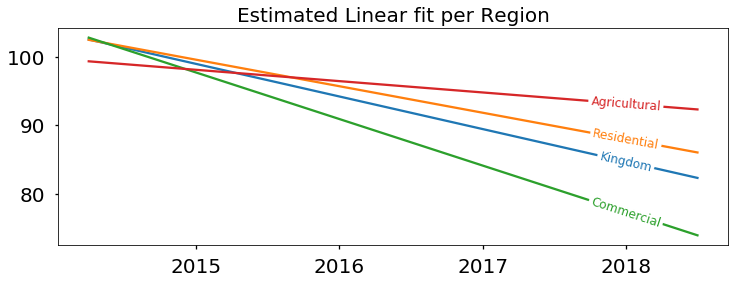

In [357]:
sectors = ['Kingdom', 'Residential', 'Commercial', 'Agricultural']

label_xvals = [
    2018.0, # Kingdom
    2018.0, # Residential
    2018.0, # Commercial
    2018.0, # Agricultural
]

plot_estimated_line(linear_results_df, repi_by_sector_df, sectors, 'Estimated Linear fit per Region', 
                    figsize=(12,4), xvals=label_xvals)


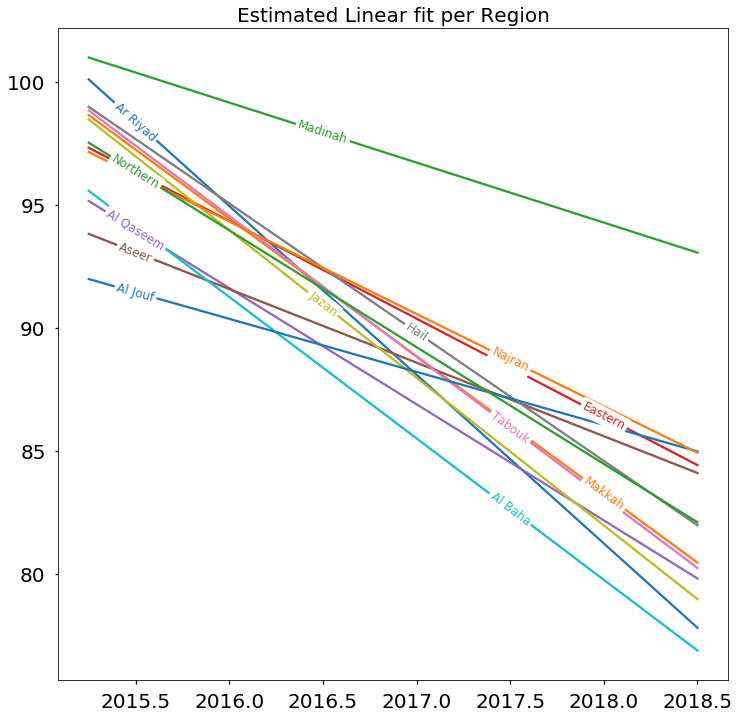

In [358]:
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')

label_xvals = [
    2015.5, # Riyadh
    2018.0, # Makkah
    2016.5, # Madinah
    2018.0, # Eastern
    2015.5, # Qaseem
    2015.5, # Aseer
    2017.5, # Tabouk
    2017.0, # Hail
    2016.5, # Jazan
    2017.5, # Al Baha
    2015.5, # Al Jouf
    2017.5, # Najran
    2015.5, # Northern
]

plot_estimated_line(linear_results_df, repi_by_region_df, regions, 'Estimated Linear fit per Region', 
                    figsize=(12,12), xvals = label_xvals)

# Exponential Decay Model

## Null test (decay = 0)

In [359]:
def decay_results(gamma, tau, a=0.05):
    
    results_df = pd.DataFrame()
    
    # ----- Per sector
    sectors = ['General', 'Residential', 'Commercial', 'Agricultural']
    X =  np.exp( - gamma * (repi_by_sector_df[['time']] - tau) ) # e^(- gamma (t - tau) )
    X = sm.add_constant(X) # Add first column of ones (intercept)

    for sector in sectors:
        Y = repi_by_sector_df[sector]

        name = sector
        if name == 'General':
            name = 'Kingdom'

        res = test_beta_zero(X, Y, a)
        res['name'] = name

        results_df = results_df.append(res, ignore_index=True)

    # # ----- Per region (plus Kingdom)
    regions = list(repi_by_region_df['Region'].unique())
    regions.remove('Kingdom')
    
    for region in regions:
        region_df = repi_by_region_df[ repi_by_region_df['Region'] == region ]

        X =  np.exp( - gamma * (region_df[['time']] - tau) ) # e^(- gamma (t - tau) )
        X = sm.add_constant(X) # Add first column of ones (intercept)
        Y = region_df['All']

        res = test_beta_zero(X, Y, a)
        res['name'] = region

        results_df = results_df.append(res, ignore_index=True)

    results_df['gamma'] = gamma
    results_df['tau'] = tau
    
    return results_df

In [360]:
# %%time

def decay_results_worker(work):
    
    results_df_list = []
    
    for gamma, tau in work:
        results_df_list.append(decay_results(gamma, tau))
        
    return pd.concat(results_df_list, ignore_index=True)
        

num_processes = 8
tau = 2014.0

gamma_tau_tuple = []
for gamma in np.linspace(0.01, 10, 1000):
    gamma_tau_tuple.append((gamma, tau))        

work_list = split(gamma_tau_tuple, num_processes)

with Pool(num_processes) as pool:
    
    results = [pool.apply_async(decay_results_worker, args=(work,)) for work in work_list]
    output = [p.get() for p in results]

decay_results_df = pd.concat(output, ignore_index=True)
decay_results_df

,beta,cih,cil,h0,intercept,name,sse,t,gamma,tau
0,4.859189e+02,5.640479e+02,4.077899e+02,0.0,-382.154215,Kingdom,62.764534,13.184635,0.01,2014.0
1,3.951441e+02,4.786152e+02,3.116729e+02,0.0,-291.674644,Residential,71.641181,10.035420,0.01,2014.0
2,6.941632e+02,7.771707e+02,6.111558e+02,0.0,-589.578096,Commercial,70.847457,17.728048,0.01,2014.0
3,1.693317e+02,2.152400e+02,1.234234e+02,0.0,-69.571355,Agricultural,21.670638,7.819228,0.01,2014.0
4,7.060765e+02,8.229765e+02,5.891765e+02,0.0,-597.130687,Ar Riyad,46.376160,13.160041,0.01,2014.0
5,5.768581e+02,7.005055e+02,4.532107e+02,0.0,-470.972055,Makkah,51.884283,10.164919,0.01,2014.0
6,2.513224e+02,2.865048e+02,2.161399e+02,0.0,-147.171426,Madinah,4.200665,15.564136,0.01,2014.0
7,4.084719e+02,5.300614e+02,2.868823e+02,0.0,-306.028986,Eastern,50.171631,7.319575,0.01,2014.0
8,4.865322e+02,6.150811e+02,3.579832e+02,0.0,-385.266813,Al Qaseem,56.079351,8.246372,0.01,2014.0
9,3.086329e+02,4.249671e+02,1.922987e+02,0.0,-210.924836,Aseer,45.928304,5.780360,0.01,2014.0


In [361]:
# Take results with smallest SSE
decay_results_df = decay_results_df.loc[decay_results_df.groupby("name")["sse"].idxmin()].reset_index()
decay_results_df

,index,beta,cih,cil,h0,intercept,name,sse,t,gamma,tau
0,904,9.630936,11.529720,7.732151,0.0,92.424059,Agricultural,12.701177,10.752495,0.54,2014.0
1,506,44.255302,49.981507,38.529098,0.0,66.695806,Al Baha,20.308009,16.839080,0.30,2014.0
2,3023,83.402353,106.454758,60.349948,0.0,86.708022,Al Jouf,17.967206,7.882827,1.78,2014.0
3,960,38.752410,46.724738,30.780083,0.0,78.669835,Al Qaseem,36.132620,10.590915,0.57,2014.0
4,38,249.222251,290.448629,207.995873,0.0,-139.762240,Ar Riyad,46.301450,13.171388,0.03,2014.0
5,2168,59.530050,64.273352,54.786748,0.0,85.877064,Aseer,2.745309,27.344841,1.28,2014.0
6,2,694.163217,777.170678,611.155755,0.0,-589.578096,Commercial,70.847457,17.728048,0.01,2014.0
7,7,408.471856,530.061388,286.882325,0.0,-306.028986,Eastern,50.171631,7.319575,0.01,2014.0
8,776,40.364495,47.445084,33.283907,0.0,78.546300,Hail,32.012338,12.420815,0.46,2014.0
9,607,45.195278,53.790700,36.599855,0.0,71.604848,Jazan,48.151185,11.456336,0.36,2014.0


## Confidence intervals

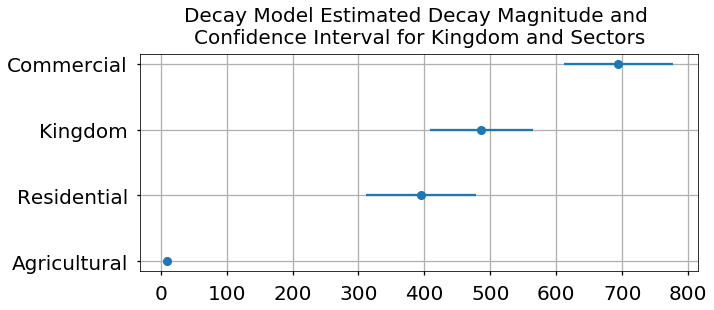

In [362]:
# Sector decay and CI
sectors = ['Kingdom', 'Residential', 'Commercial', 'Agricultural']
title = 'Decay Model Estimated Decay Magnitude and \nConfidence Interval for Kingdom and Sectors'
plot_beta_confidence(decay_results_df, sectors, title, figsize=(10,4) ,ascending=True)

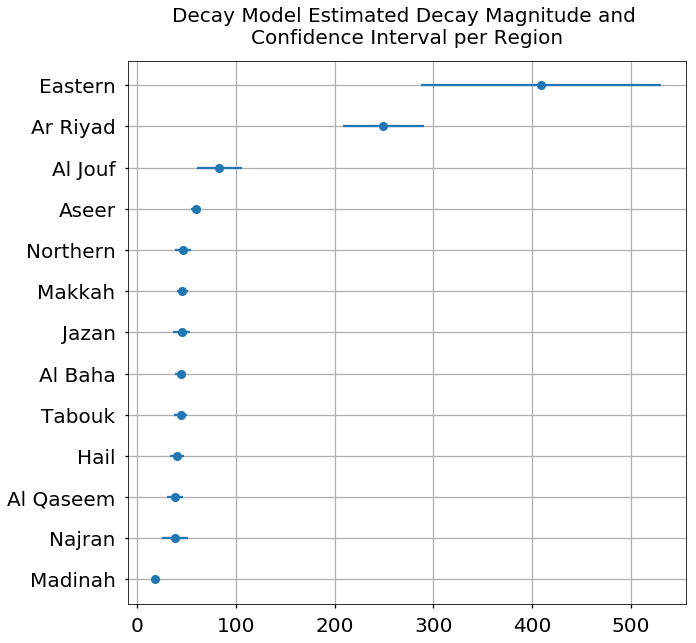

In [363]:
# Regional decay and CI
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')
title = 'Decay Model Estimated Decay Magnitude and \nConfidence Interval per Region'
plot_beta_confidence(decay_results_df, regions, title, figsize=(10,10) ,ascending=True)

## Plot Estimated Decay

In [364]:
def plot_estimated_decay(results_df, data_df, names, title, figsize=FIGURE_SIZE, xvals=None):

    x_min = data_df['time'].min()
    x_max = data_df['time'].max()
    x = np.linspace(x_min, x_max, 1000)
    
    plt.rcParams["figure.figsize"] = figsize

    for name in names:
        result    = results_df[ results_df['name'] == name].iloc[0]
        decay     = result['beta']
        intercept = result['intercept']
        tau       = result['tau']
        gamma     = result['gamma']


        estimate_y = np.exp( - gamma * (x - tau) )*decay + intercept
    
        plt.plot(
            x,
            estimate_y,
            label=name
        )

    plt.title(title, fontsize=FONT_SIZE)
    
    if xvals is None:
        plt.legend()
    elif type(xvals) == list:
        labelLines(plt.gca().get_lines(), align=True, fontsize=12, xvals=xvals)
    else:
        labelLines(plt.gca().get_lines(), align=True, fontsize=12)
    
    plt.show()

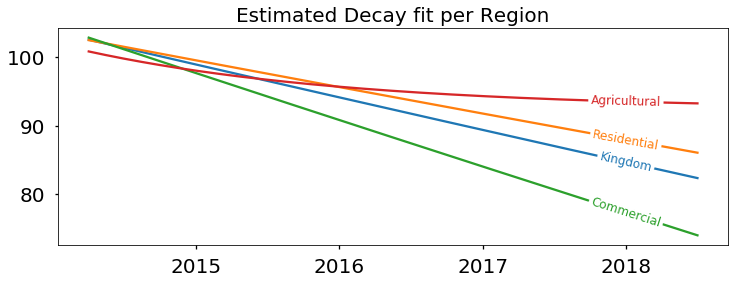

In [365]:
sectors = ['Kingdom', 'Residential', 'Commercial', 'Agricultural']

label_xvals = [
    2018.0, # Kingdom
    2018.0, # Residential
    2018.0, # Commercial
    2018.0, # Agricultural
]

plot_estimated_decay(decay_results_df, repi_by_sector_df, sectors, 'Estimated Decay fit per Region', 
                    figsize=(12,4), xvals=label_xvals)


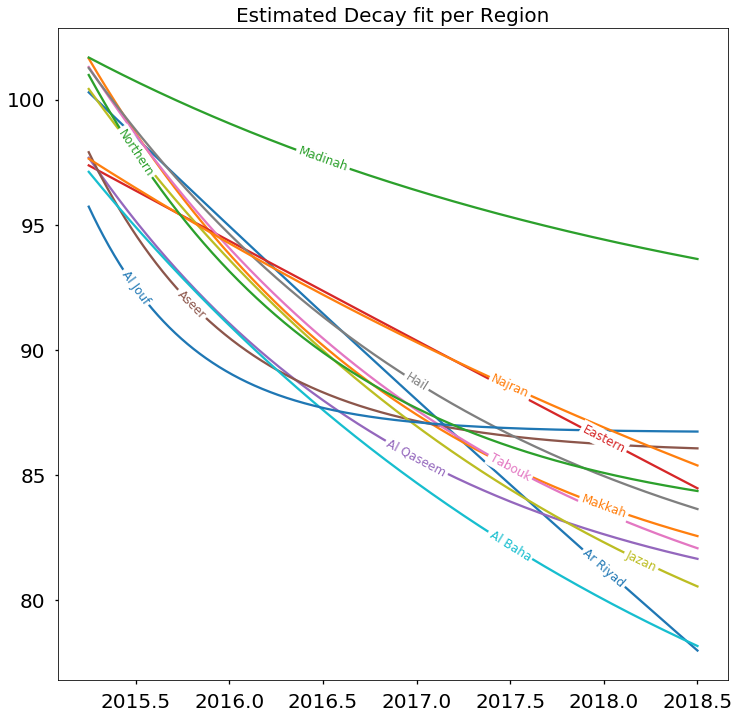

In [366]:
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')

label_xvals = [
    2018.0, # Riyadh
    2018.0, # Makkah
    2016.5, # Madinah
    2018.0, # Eastern
    2017.0, # Qaseem
    2015.8, # Aseer
    2017.5, # Tabouk
    2017.0, # Hail
    2018.2, # Jazan
    2017.5, # Al Baha
    2015.5, # Al Jouf
    2017.5, # Najran
    2015.5, # Northern
]

plot_estimated_decay(decay_results_df, repi_by_region_df, regions, 'Estimated Decay fit per Region', 
                    figsize=(12,12), xvals = label_xvals)

# Linear + Decay -> Linear

In [367]:
linear_decay_f_results_df = pd.DataFrame()
a = 0.05

# -- Per sector
sectors = ['General', 'Residential', 'Commercial', 'Agricultural']
times = repi_by_sector_df['time']

for sector in sectors:
    Y = repi_by_sector_df[sector]
    
    name = sector
    if name == 'General':
        name = 'Kingdom'
        
    if len(decay_results_df[ decay_results_df['name'] == name ]) > 1:
        raise "Please reduce decay_results_df to a single row per sector " \
                "by taking the minimum SSE for each sector"
    
    # Pick best tau and gamma from previous results
    tau_gamma = decay_results_df[ decay_results_df['name'] == name ].iloc[0]
    tau       = tau_gamma['tau']
    gamma     = tau_gamma['gamma']
    
    X = pd.DataFrame()
    X['b0'] = np.ones(len(times))
    X['b1'] = times
    X['b2'] = np.exp( - gamma * (times - tau) )
    
    res = test_reduced_model(X, Y, ['b2'], a=a)
    res['name'] = name
    
    linear_decay_f_results_df = linear_decay_f_results_df.append(res, ignore_index=True)
    
# --- Per region
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')

for region in regions:
    region_df = repi_by_region_df[ repi_by_region_df['Region'] == region ]
    
    Y = region_df['All'].reset_index(drop=True)
    
    name = region
    
    if len(decay_results_df[ decay_results_df['name'] == name ]) > 1:
        raise "Please reduce decay_results_df to a single row per region " \
                "by taking the minimum SSE for each region"
    
    # Pick best tau and gamma from previous results
    tau_gamma = decay_results_df[ decay_results_df['name'] == name ].iloc[0]
    tau       = tau_gamma['tau']
    gamma     = tau_gamma['gamma']
        
    times = region_df['time'].reset_index(drop=True)
    
    X = pd.DataFrame()
    X['b0'] = np.ones(len(times))
    X['b1'] = times
    X['b2'] = np.exp( - gamma * (times - tau) )
        
    res = test_reduced_model(X, Y, ['b2'], a=a)
    res['name'] = name
    
    linear_decay_f_results_df = linear_decay_f_results_df.append(res, ignore_index=True)
    
linear_decay_f_results_df

,betas_full,betas_rest,f_threshold,f_value,h0,name
0,b0 165091.499814 b1 -78.187301 b2 ...,b0 9666.123529 b1 -4.747988 dtype: flo...,4.543077,1.442853,1.0,Kingdom
1,b0 231153.029628 b1 -109.359021 b2 ...,b0 7882.554248 b1 -3.862539 dtype: flo...,4.543077,2.828680,1.0,Residential
2,b0 71431.838950 b1 -34.030555 b2 -2...,b0 13759.747059 b1 -6.780186 dtype: f...,4.543077,0.161355,1.0,Commercial
3,b0 -256.437367 b1 0.172855 b2 10.54...,b0 3423.547059 b1 -1.650361 dtype: flo...,4.543077,11.144366,0.0,Agricultural
4,b0 -2608.566357 b1 1.204172 b2 292...,b0 13925.707694 b1 -6.860484 dtype: f...,4.844336,0.039546,1.0,Ar Riyad
5,b0 -1253.333874 b1 0.659944 b2 50...,b0 11379.751465 b1 -5.597861 dtype: f...,4.844336,19.506479,0.0,Makkah
6,b0 -372.041112 b1 0.228227 b2 20.38...,b0 5018.924945 b1 -2.440352 dtype: flo...,4.844336,8.866443,0.0,Madinah
7,b0 196073.713204 b1 -92.768698 b2 ...,b0 8099.756922 b1 -3.970930 dtype: flo...,4.844336,0.516826,1.0,Eastern
8,b0 -78.262935 b1 0.077742 b2 39.35194...,b0 9611.819817 b1 -4.722315 dtype: flo...,4.844336,6.292135,0.0,Al Qaseem
9,b0 -524.905585 b1 0.302718 b2 64.11...,b0 6121.634249 b1 -2.991092 dtype: flo...,4.844336,197.765560,0.0,Aseer


## f values and threshold

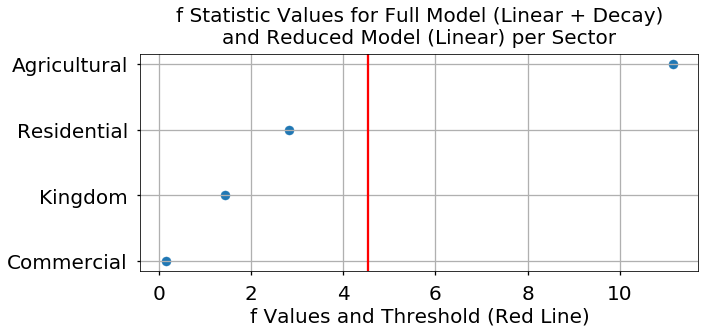

In [368]:
names = ['Kingdom', 'Residential', 'Commercial', 'Agricultural']

title = 'f Statistic Values for Full Model (Linear + Decay)\nand Reduced Model (Linear) per Sector'
plot_f_and_threshold(linear_decay_f_results_df, names, title, figsize=(10, 4))

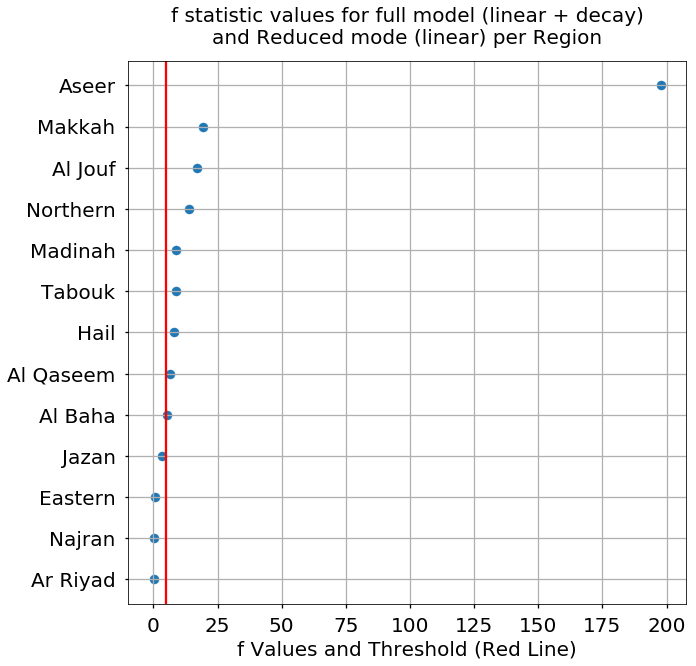

In [369]:
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')

title = 'f statistic values for full model (linear + decay)\nand Reduced mode (linear) per Region'
plot_f_and_threshold(linear_decay_f_results_df, regions, title, figsize=(10, 10))

# FFT

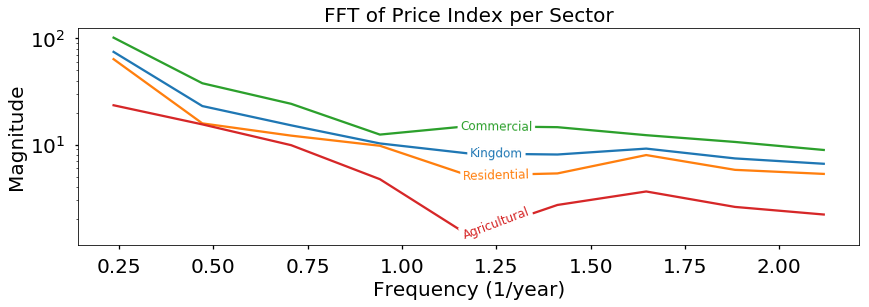

In [370]:
sectors = ['General', 'Residential', 'Commercial', 'Agricultural']
names = sectors

xvals = [
    1.25,
    1.25,
    1.25,
    1.25,
]

plt.rcParams["figure.figsize"] = (14, 4)

for name in names: 
    values = repi_by_sector_df[name]
    times = repi_by_sector_df['time']
        
    if name == 'General':
        name = 'Kingdom'

    fft_abs = np.abs(np.fft.rfft(values))
    xvalues = np.linspace(0, len(fft_abs) - 1, len(fft_abs)) / (times.max() - times.min())

    plt.plot(
        xvalues[1:],
        fft_abs[1:],
        label=name,
    )
    
plt.yscale('log')
plt.xlabel('Frequency (1/year)', fontsize=FONT_SIZE)
plt.ylabel('Magnitude', fontsize=FONT_SIZE)
plt.title('FFT of Price Index per Sector', fontsize=FONT_SIZE)
labelLines(plt.gca().get_lines(), align=True, fontsize=12, xvals=xvals)
plt.show()

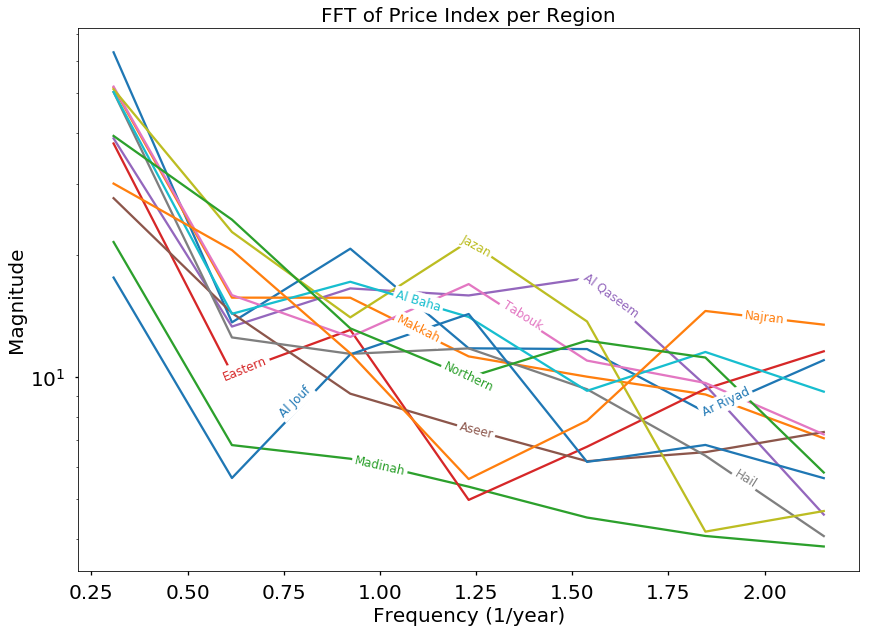

In [371]:
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')

xvals = [
    1.9, # Riyadh
    1.1, # Makkah
    1, # Madinah
    0.65, # Eastern
    1.6, # Qaseem
    1.25, # Aseer
    1.37, # Tabouk
    1.95, # Hail
    1.25, # Jazan
    1.1, # Al Baha
    0.78, # Al Jouf
    2, # Najran
    1.23, # Northern
]

names = regions

plt.rcParams["figure.figsize"] = (14, 10)

for name in names: 
    values = repi_by_region_df[ repi_by_region_df['Region'] == name ]['All']
    times = repi_by_region_df[ repi_by_region_df['Region'] == name ]['time'].reset_index(drop=True)

    fft_abs = np.abs(np.fft.rfft(values))
    xvalues = np.linspace(0, len(fft_abs) - 1, len(fft_abs)) / (times.max() - times.min())

    plt.plot(
        xvalues[1:],
        fft_abs[1:],
        label=name,
    )
    
plt.yscale('log')
plt.xlabel('Frequency (1/year)', fontsize=FONT_SIZE)
plt.ylabel('Magnitude', fontsize=FONT_SIZE)
plt.title('FFT of Price Index per Region', fontsize=FONT_SIZE)
labelLines(plt.gca().get_lines(), align=True, fontsize=12, xvals=xvals)
# plt.legend()
plt.show()

# Linear + Periodic -> Linear

In [372]:
linear_periodic_f_results_df = pd.DataFrame()
a = 0.05

# -- Per sector
sectors = ['General', 'Residential', 'Commercial', 'Agricultural']
times = repi_by_sector_df['time']

for sector in sectors:
    Y = repi_by_sector_df[sector]
    
    name = sector
    if name == 'General':
        name = 'Kingdom'
    
    X = pd.DataFrame()
    X['b0'] = np.ones(len(times))
    X['b1'] = times
    X['b2'] = np.cos(2.0 * np.pi * times * 4.0)
    X['b3'] = np.sin(2.0 * np.pi * times * 4.0)
    
    res = test_reduced_model(X, Y, ['b2', 'b3'], a=a)
    res['name'] = name
    
    linear_periodic_f_results_df = linear_periodic_f_results_df.append(res, ignore_index=True)
    
# --- Per region
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')

for region in regions:
    region_df = repi_by_region_df[ repi_by_region_df['Region'] == region ]
    
    Y = region_df['All'].reset_index(drop=True)
    
    name = region
        
    times = region_df['time'].reset_index(drop=True)
    
    X = pd.DataFrame()
    X['b0'] = np.ones(len(times))
    X['b1'] = times
    X['b2'] = np.cos(2.0 * np.pi * times * 4.0)
    X['b3'] = np.sin(2.0 * np.pi * times * 4.0)
        
    res = test_reduced_model(X, Y, ['b2', 'b3'], a=a)
    res['name'] = name
    
    linear_periodic_f_results_df = linear_periodic_f_results_df.append(res, ignore_index=True)
    
linear_periodic_f_results_df

,betas_full,betas_rest,f_threshold,f_value,h0,name
0,b0 -4.658252e+05 b1 -4.755923e+00 b2 4....,b0 9666.123529 b1 -4.747988 dtype: flo...,4.543077,0.017605,1.0,Kingdom
1,b0 -1.422889e+06 b1 -3.886596e+00 b2 1....,b0 7882.554248 b1 -3.862539 dtype: flo...,4.543077,0.142945,1.0,Residential
2,b0 7.932677e+05 b1 -6.766927e+00 b2 -7....,b0 13759.747059 b1 -6.780186 dtype: f...,4.543077,0.043365,1.0,Commercial
3,b0 1.814484e+06 b1 -1.619796e+00 b2 -1....,b0 3423.547059 b1 -1.650361 dtype: flo...,4.543077,0.773386,1.0,Agricultural
4,b0 8.885174e+05 b1 -6.867076e+00 b2 -8....,b0 13925.707694 b1 -6.860484 dtype: f...,4.844336,0.047475,1.0,Ar Riyad
5,b0 4.264093e+05 b1 -5.601007e+00 b2 -4....,b0 11379.751465 b1 -5.597861 dtype: f...,4.844336,0.009434,1.0,Makkah
6,b0 2.007808e+05 b1 -2.441834e+00 b2 -1....,b0 5018.924945 b1 -2.440352 dtype: flo...,4.844336,0.025769,1.0,Madinah
7,b0 -1.112725e+06 b1 -3.962578e+00 b2 1....,b0 8099.756922 b1 -3.970930 dtype: flo...,4.844336,0.071001,1.0,Eastern
8,b0 9.773925e+05 b1 -4.729589e+00 b2 -9....,b0 9611.819817 b1 -4.722315 dtype: flo...,4.844336,0.047276,1.0,Al Qaseem
9,b0 -9.785820e+05 b1 -2.983750e+00 b2 9....,b0 6121.634249 b1 -2.991092 dtype: flo...,4.844336,0.058756,1.0,Aseer


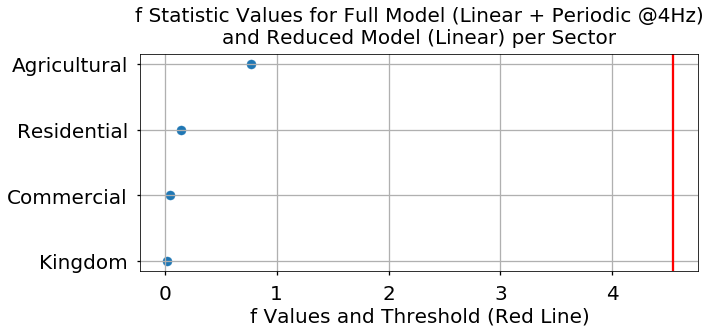

In [373]:
names = ['Kingdom', 'Residential', 'Commercial', 'Agricultural']
title = 'f Statistic Values for Full Model (Linear + Periodic @4Hz)\nand Reduced Model (Linear) per Sector'
plot_f_and_threshold(linear_periodic_f_results_df, names, title, figsize=(10, 4))

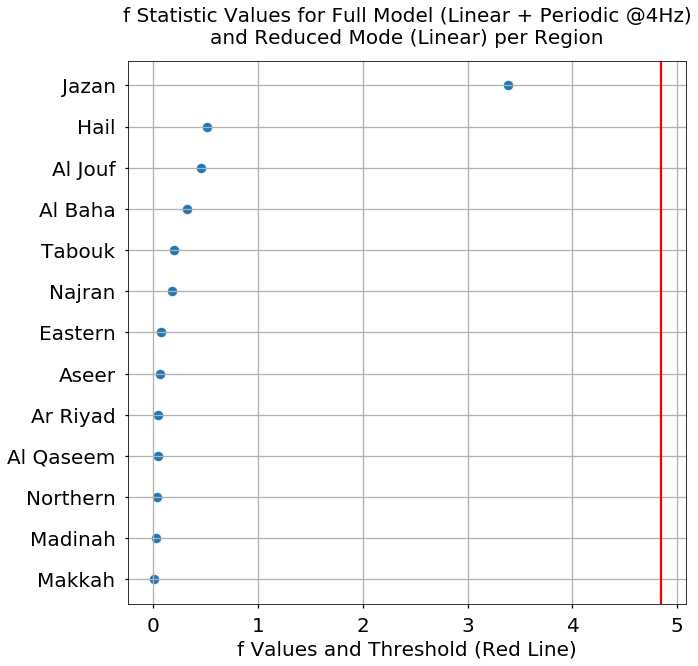

In [374]:
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')

title = 'f Statistic Values for Full Model (Linear + Periodic @4Hz)\nand Reduced Mode (Linear) per Region'
plot_f_and_threshold(linear_periodic_f_results_df, regions, title, figsize=(10, 10))

In [341]:
linear_periodic_f_results_df = pd.DataFrame()
a = 0.05

# -- Per sector
sectors = ['General', 'Residential', 'Commercial', 'Agricultural']
times = repi_by_sector_df['time']

for sector in sectors:
    Y = repi_by_sector_df[sector]
    
    name = sector
    if name == 'General':
        name = 'Kingdom'
    
    X = pd.DataFrame()
    X['b0'] = np.ones(len(times))
    X['b1'] = times
    X['b2'] = np.cos(2.0 * np.pi * times * 2.0)
    X['b3'] = np.sin(2.0 * np.pi * times * 2.0)
    
    res = test_reduced_model(X, Y, ['b2', 'b3'], a=a)
    res['name'] = name
    
    linear_periodic_f_results_df = linear_periodic_f_results_df.append(res, ignore_index=True)
    
# --- Per region
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')

for region in regions:
    region_df = repi_by_region_df[ repi_by_region_df['Region'] == region ]
    
    Y = region_df['All'].reset_index(drop=True)
    
    name = region
        
    times = region_df['time'].reset_index(drop=True)
    
    X = pd.DataFrame()
    X['b0'] = np.ones(len(times))
    X['b1'] = times
    X['b2'] = np.cos(2.0 * np.pi * times * 4.0)
    X['b3'] = np.sin(2.0 * np.pi * times * 4.0)
        
    res = test_reduced_model(X, Y, ['b2', 'b3'], a=a)
    res['name'] = name
    
    linear_periodic_f_results_df = linear_periodic_f_results_df.append(res, ignore_index=True)
    
linear_periodic_f_results_df

,betas_full,betas_rest,f_threshold,f_value,h0,name
0,b0 9700.426875 b1 -4.765000 b2 0...,b0 9666.123529 b1 -4.747988 dtype: flo...,4.543077,0.229488,1.0,Kingdom
1,b0 7911.041528 b1 -3.876667 b2 0...,b0 7882.554248 b1 -3.862539 dtype: flo...,4.543077,0.137838,1.0,Residential
2,b0 13813.142500 b1 -6.806667 b2 ...,b0 13759.747059 b1 -6.780186 dtype: f...,4.543077,0.498437,1.0,Commercial
3,b0 3436.261250 b1 -1.656667 b2 0...,b0 3423.547059 b1 -1.650361 dtype: flo...,4.543077,0.088061,1.0,Agricultural
4,b0 8.885174e+05 b1 -6.867076e+00 b2 -8....,b0 13925.707694 b1 -6.860484 dtype: f...,4.844336,0.047475,1.0,Ar Riyad
5,b0 4.264093e+05 b1 -5.601007e+00 b2 -4....,b0 11379.751465 b1 -5.597861 dtype: f...,4.844336,0.009434,1.0,Makkah
6,b0 2.007808e+05 b1 -2.441834e+00 b2 -1....,b0 5018.924945 b1 -2.440352 dtype: flo...,4.844336,0.025769,1.0,Madinah
7,b0 -1.112725e+06 b1 -3.962578e+00 b2 1....,b0 8099.756922 b1 -3.970930 dtype: flo...,4.844336,0.071001,1.0,Eastern
8,b0 9.773925e+05 b1 -4.729589e+00 b2 -9....,b0 9611.819817 b1 -4.722315 dtype: flo...,4.844336,0.047276,1.0,Al Qaseem
9,b0 -9.785820e+05 b1 -2.983750e+00 b2 9....,b0 6121.634249 b1 -2.991092 dtype: flo...,4.844336,0.058756,1.0,Aseer


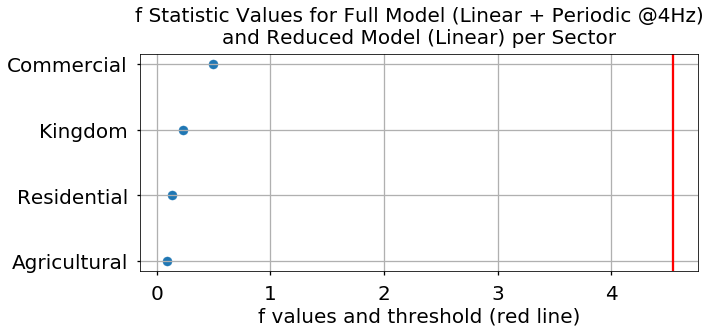

In [342]:
names = ['Kingdom', 'Residential', 'Commercial', 'Agricultural']
title = 'f Statistic Values for Full Model (Linear + Periodic @2Hz)\nand Reduced Model (Linear) per Sector'
plot_f_and_threshold(linear_periodic_f_results_df, names, title, figsize=(10, 4))

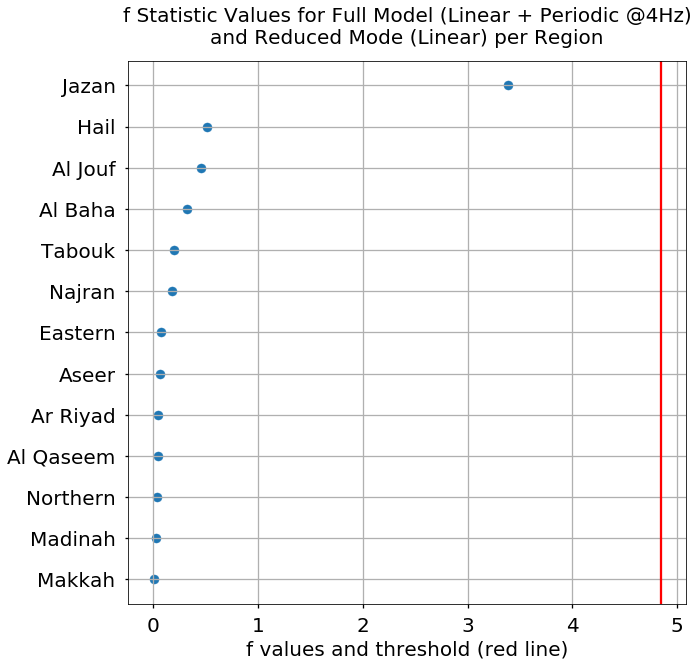

In [343]:
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')

title = 'f Statistic Values for Full Model (Linear + Periodic @2Hz)\nand Reduced Mode (Linear) per Region'
plot_f_and_threshold(linear_periodic_f_results_df, regions, title, figsize=(10, 10))

# Other

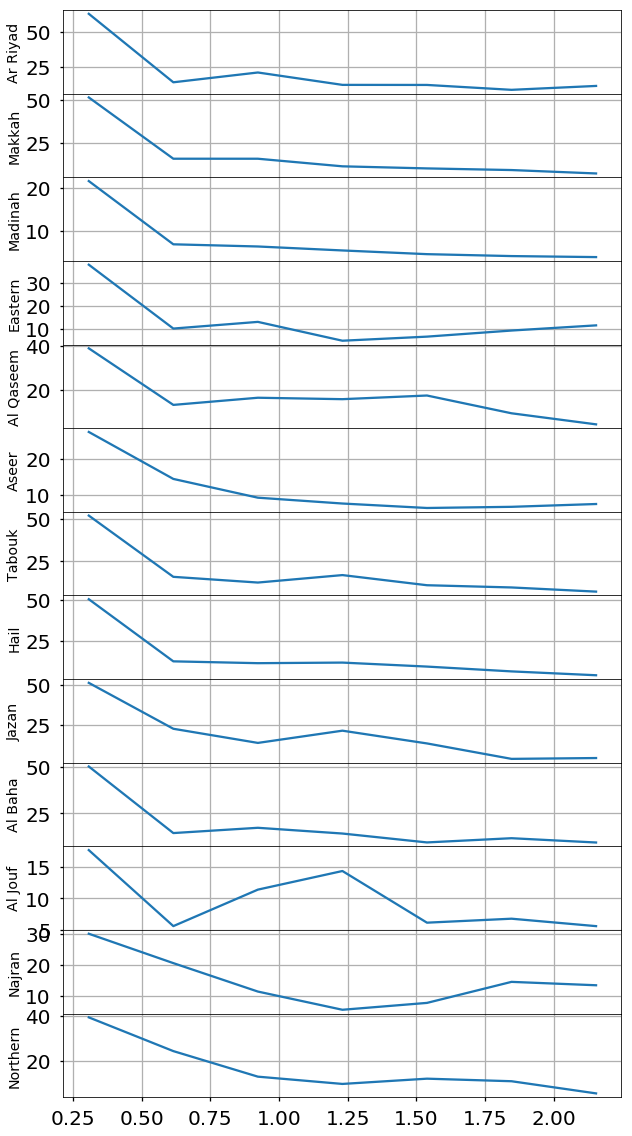

In [260]:
# def plot_ffts(data_df, names, title, figsize=FIGURE_SIZE):

regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')

names = regions
    
fig, axes = plt.subplots(len(names), 1, figsize=(10, 20), sharex=True)
fig.subplots_adjust(hspace=0)

for i, name in enumerate(names):

    values = repi_by_region_df[ repi_by_region_df['Region'] == name ]['All']
    times = repi_by_region_df[ repi_by_region_df['Region'] == name ]['time'].reset_index(drop=True)

    xvalues = np.linspace(0, len(fft_abs) - 1, len(fft_abs)) / (times.max() - times.min())
    fft_abs = np.abs(np.fft.rfft(values))

    ax = axes[i]
    ax.plot(
        xvalues[1:],
        fft_abs[1:],
    )

    ax.set_ylabel(name)
    ax.grid()
        
plt.show()
    

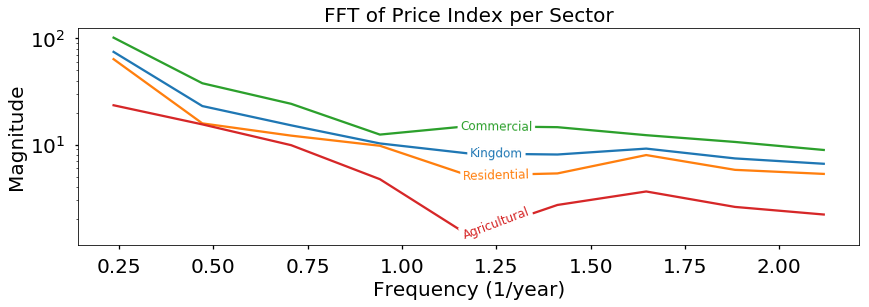

In [304]:
sectors = ['General', 'Residential', 'Commercial', 'Agricultural']
names = sectors

xvals = [
    1.25,
    1.25,
    1.25,
    1.25,
]

plt.rcParams["figure.figsize"] = (14, 4)

for name in names: 
    values = repi_by_sector_df[name]
    times = repi_by_sector_df['time']
        
    if name == 'General':
        name = 'Kingdom'

    xvalues = np.linspace(0, len(fft_abs) - 1, len(fft_abs)) / (times.max() - times.min())
    fft_abs = np.abs(np.fft.rfft(values))

    plt.plot(
        xvalues[1:],
        fft_abs[1:],
        label=name,
    )
    
plt.yscale('log')
plt.xlabel('Frequency (1/year)', fontsize=FONT_SIZE)
plt.ylabel('Magnitude', fontsize=FONT_SIZE)
plt.title('FFT of Price Index per Sector', fontsize=FONT_SIZE)
labelLines(plt.gca().get_lines(), align=True, fontsize=12, xvals=xvals)
# plt.legend()
plt.show()

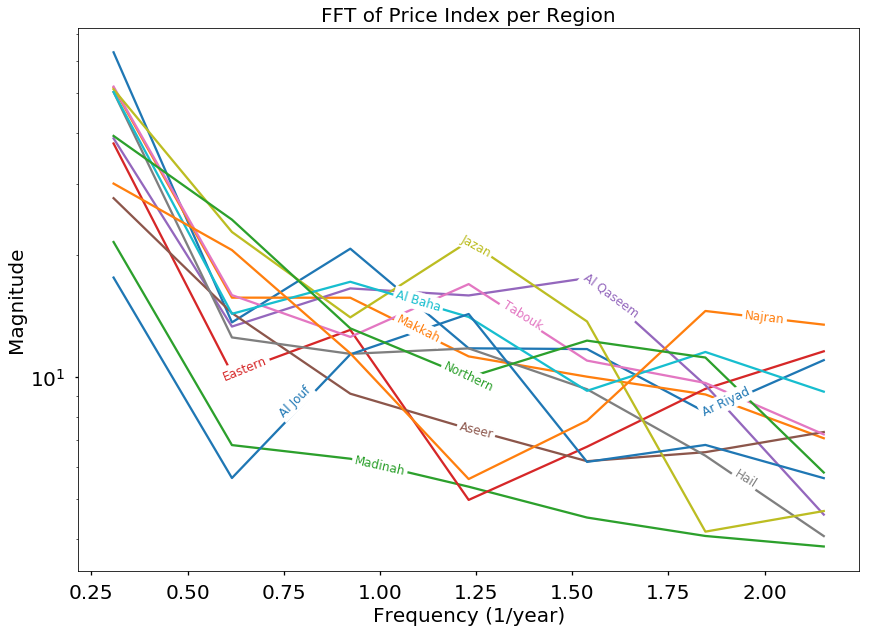

In [283]:
regions = list(repi_by_region_df['Region'].unique())
regions.remove('Kingdom')

xvals = [
    1.9, # Riyadh
    1.1, # Makkah
    1, # Madinah
    0.65, # Eastern
    1.6, # Qaseem
    1.25, # Aseer
    1.37, # Tabouk
    1.95, # Hail
    1.25, # Jazan
    1.1, # Al Baha
    0.78, # Al Jouf
    2, # Najran
    1.23, # Northern
]

names = regions

plt.rcParams["figure.figsize"] = (14, 10)

for name in names: 
    values = repi_by_region_df[ repi_by_region_df['Region'] == name ]['All']
    times = repi_by_region_df[ repi_by_region_df['Region'] == name ]['time'].reset_index(drop=True)

    xvalues = np.linspace(0, len(fft_abs) - 1, len(fft_abs)) / (times.max() - times.min())
    fft_abs = np.abs(np.fft.rfft(values))

    plt.plot(
        xvalues[1:],
        fft_abs[1:],
        label=name,
    )
    
plt.yscale('log')
plt.xlabel('Frequency (1/year)', fontsize=FONT_SIZE)
plt.ylabel('Magnitude', fontsize=FONT_SIZE)
plt.title('FFT of Price Index per Region', fontsize=FONT_SIZE)
labelLines(plt.gca().get_lines(), align=True, fontsize=12, xvals=xvals)
# plt.legend()
plt.show()

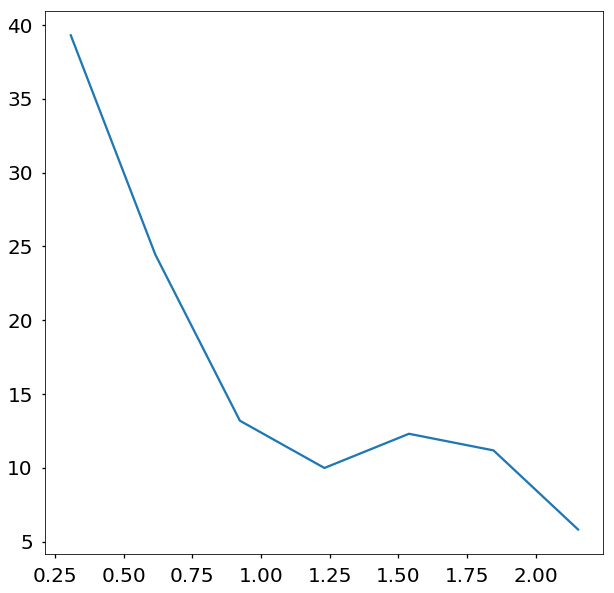

In [240]:
values = repi_by_region_df[ repi_by_region_df['Region'] == region ]['All']
times = repi_by_region_df[ repi_by_region_df['Region'] == region ]['time'].reset_index(drop=True)
fft_abs = np.abs(np.fft.rfft(values))

# values = [0, 1, 1, 0, -1, -1] * 3
# fft_abs = np.abs(np.fft.rfft(values))

(times.max() - times.min())

np.linspace(0, len(fft_abs) - 1, len(fft_abs)) / (times.max() - times.min())

# len(fft_abs)

plt.plot(
    (np.linspace(0, len(fft_abs) - 1, len(fft_abs)) / (times.max() - times.min()))[1:],
    fft_abs[1:],
)

# plt.yscale('log')

In [ ]:
X = sm.add_constant(repi_by_sector_df[['time']] - 2014.25)
Y = repi_by_sector_df['General']

mod = sm.OLS(Y, X)

res = mod.fit()

# res.summary()

# res.cov_params()

# CI
# res.conf_int()

# t.stat
# res.tvalues

# np.sum( res.resid ** 2)

# hypotheses = 'time = 0'

# res.t_test(hypotheses).summary_frame()

# res.mse_resid

# theta = 

